# Trabalho Prático 2 – Aprendizado Não Supervisionado  
## Segmentação de Clientes com Algoritmos de Clusterização

### Equipe:
* Francisco Djalma Pereira da Silva Júnior - 554222
* Francisco Leudes Bezerra Neto - 552478
* Pablo Vinícius da Silva Araújo - 574229

### Objetivo:
O objetivo principal deste projeto é aplicar, comparar e avaliar o desempenho de três algoritmos de clusterização distintos a um conjunto de dados real. O processo envolve todas as etapas de um projeto de ciência de dados, desde a exploração e pré-processamento dos dados até a aplicação dos modelos e a interpretação dos resultados. Ao final, buscamos identificar segmentos (clusters) de clientes com perfis e comportamentos semelhantes, que possam ser utilizados para direcionar estratégias de marketing mais eficazes.

### Descrição do Conjunto de Dados:
Para este trabalho, foi selecionado o dataset **"Customer Personality Analysis"**, disponível publicamente na plataforma Kaggle.
* **Fonte:** [Kaggle - Customer Personality Analysis](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)
* **Amostras:** O dataset original contém **2.240** registros de clientes.
* **Características:** Possui **29** atributos (features) que detalham o perfil de cada consumidor em quatro categorias principais:
    * **Pessoas:** Dados demográficos como ano de nascimento, educação, estado civil e renda.
    * **Produtos:** Gastos em diferentes categorias de produtos (vinhos, carnes, frutas, etc.).
    * **Promoções:** Engajamento dos clientes com campanhas de marketing anteriores.
    * **Lugar:** Canais de compra utilizados pelos clientes (loja física, site, catálogo).

Este conjunto de dados é ideal para a tarefa de clusterização, pois não possui rótulos predefinidos (variável alvo), característica típica de problemas de aprendizado não supervisionado. A riqueza de atributos comportamentais e demográficos torna possível a identificação de segmentos relevantes.

### Algoritmos Utilizados

- **K-Means:** Rápido e eficiente para grandes datasets; assume clusters esféricos e de tamanho similar.
- **Hierárquico (Aglomerativo):** Permite análise mais interpretável via dendrograma; não requer definição prévia do número de clusters.
- **DBSCAN:** Identifica clusters de formatos arbitrários e detecta outliers naturalmente.

### Pipeline do Projeto
1. Importação e visualização inicial dos dados
2. Limpeza de dados e engenharia de atributos
3. Análise exploratória e identificação de outliers
4. Pré-processamento (normalização e codificação)
5. Aplicação dos algoritmos de clusterização
6. Avaliação e comparação dos modelos
7. Visualização com PCA e t-SNE
8. Perfilamento e interpretação dos clusters

### Divisão de Tarefas:

| Etapa                                          | Djalma | Leudes | Pablo |
|------------------------------------------------|:------:|:------:|:-----:|
| Escolha do dataset e definição do problema     |   ✔    |   ✔    |   ✔   |
| Importação e visualização inicial dos dados    |        |   ✔    |       |
| Limpeza e engenharia de features               |   ✔    |        |       |
| Análise exploratória e remoção de outliers     |        |        |   ✔   |
| Pré-processamento (encoding e scaling)         |   ✔    |        |   ✔   |
| Modelagem com K-Means                          |   ✔    |        |       |
| Modelagem com Clusterização Hierárquica        |        |   ✔    |       |
| Modelagem com DBSCAN                           |        |        |   ✔   |
| Avaliação dos modelos                          |   ✔    |   ✔    |   ✔   |
| Visualização dos clusters (PCA e t-SNE)        |   ✔    |        |       |
| Conclusão e perfilamento                       |   ✔    |   ✔    |   ✔   |


# Importação de bibliotecas


In [139]:
# Importação das bibliotecas para manipulação de dados, matemática e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importação das ferramentas de Machine Learning do Scikit-learn que serão usadas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Importação de bibliotecas para ajudar com a visualização e avisos
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage

# --- CONFIGURAÇÕES GERAIS ---
# Ignorar avisos de bibliotecas para um output mais limpo
warnings.filterwarnings("ignore")
# Define um estilo visual padrão para os gráficos
sns.set_style("whitegrid")


import missingno as mn

# Leitura do dataset

In [140]:
try:
    # O arquivo 'marketing_campaign.csv' deve estar na mesma pasta que o seu notebook
    df = pd.read_csv('marketing_campaign.csv', sep='\t')
    print("--- Dataset Carregado com Sucesso! ---")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: O arquivo 'marketing_campaign.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo está na mesma pasta que o seu notebook.")

--- Dataset Carregado com Sucesso! ---
O dataset tem 2240 linhas e 29 colunas.


# Primeira análise do dataset

In [141]:
# 1. Visualização das primeiras linhas do dataset
print("\n--- Visualizando as 5 primeiras linhas do dataset: ---")
display(df.head())


--- Visualizando as 5 primeiras linhas do dataset: ---


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Verificação de Tipos de Dados e Contagem de Nulos

O `.info()` nos dá uma visão rápida sobre os tipos de dados e a presença de valores nulos.

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Estatísticas Descritivas (Numéricas)

O `.describe()` resume as principais métricas estatísticas das colunas numéricas.

In [143]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


### Contagem de Valores Nulos por Coluna

A presença de dados ausentes é um dos problemas mais comuns em projetos de ciência de dados. É crucial identificá-los e tratá-los corretamente, pois a maioria dos algoritmos de Machine Learning não funciona com valores nulos.

**O Impacto dos Dados Ausentes:**

- **Redução do Poder Estatístico:** A ausência de dados diminui o tamanho da amostra, o que pode enfraquecer os resultados de testes estatísticos e a confiança nos modelos.
- **Viés nos Resultados:** Se os dados não estiverem faltando de forma completamente aleatória, a sua ausência pode introduzir um viés significativo. Por exemplo, se pessoas com renda mais baixa tendem a não informar sua renda, qualquer análise sobre o impacto da renda no consumo será distorcida.
- **Problemas Técnicos:** Como mencionado, algoritmos como k-Means param ou geram erros ao encontrar valores nulos.

Vamos agora visualizar detalhadamente onde estão os nossos dados ausentes.

In [144]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percentage], axis=1, keys=['Total', 'Porcentagem'])

print("\n\n--- Análise de Dados Ausentes por Coluna ---")
missing_values = missing_data(df)
display(missing_values.style.background_gradient(cmap='Reds'))



--- Análise de Dados Ausentes por Coluna ---


,Total,Porcentagem
Income,24,1.071429
ID,0,0.000000
Year_Birth,0,0.000000
Education,0,0.000000
Marital_Status,0,0.000000
Kidhome,0,0.000000
Teenhome,0,0.000000
Dt_Customer,0,0.000000
Recency,0,0.000000
MntWines,0,0.000000




--- Matriz de Valores Ausentes ---


<Axes: >

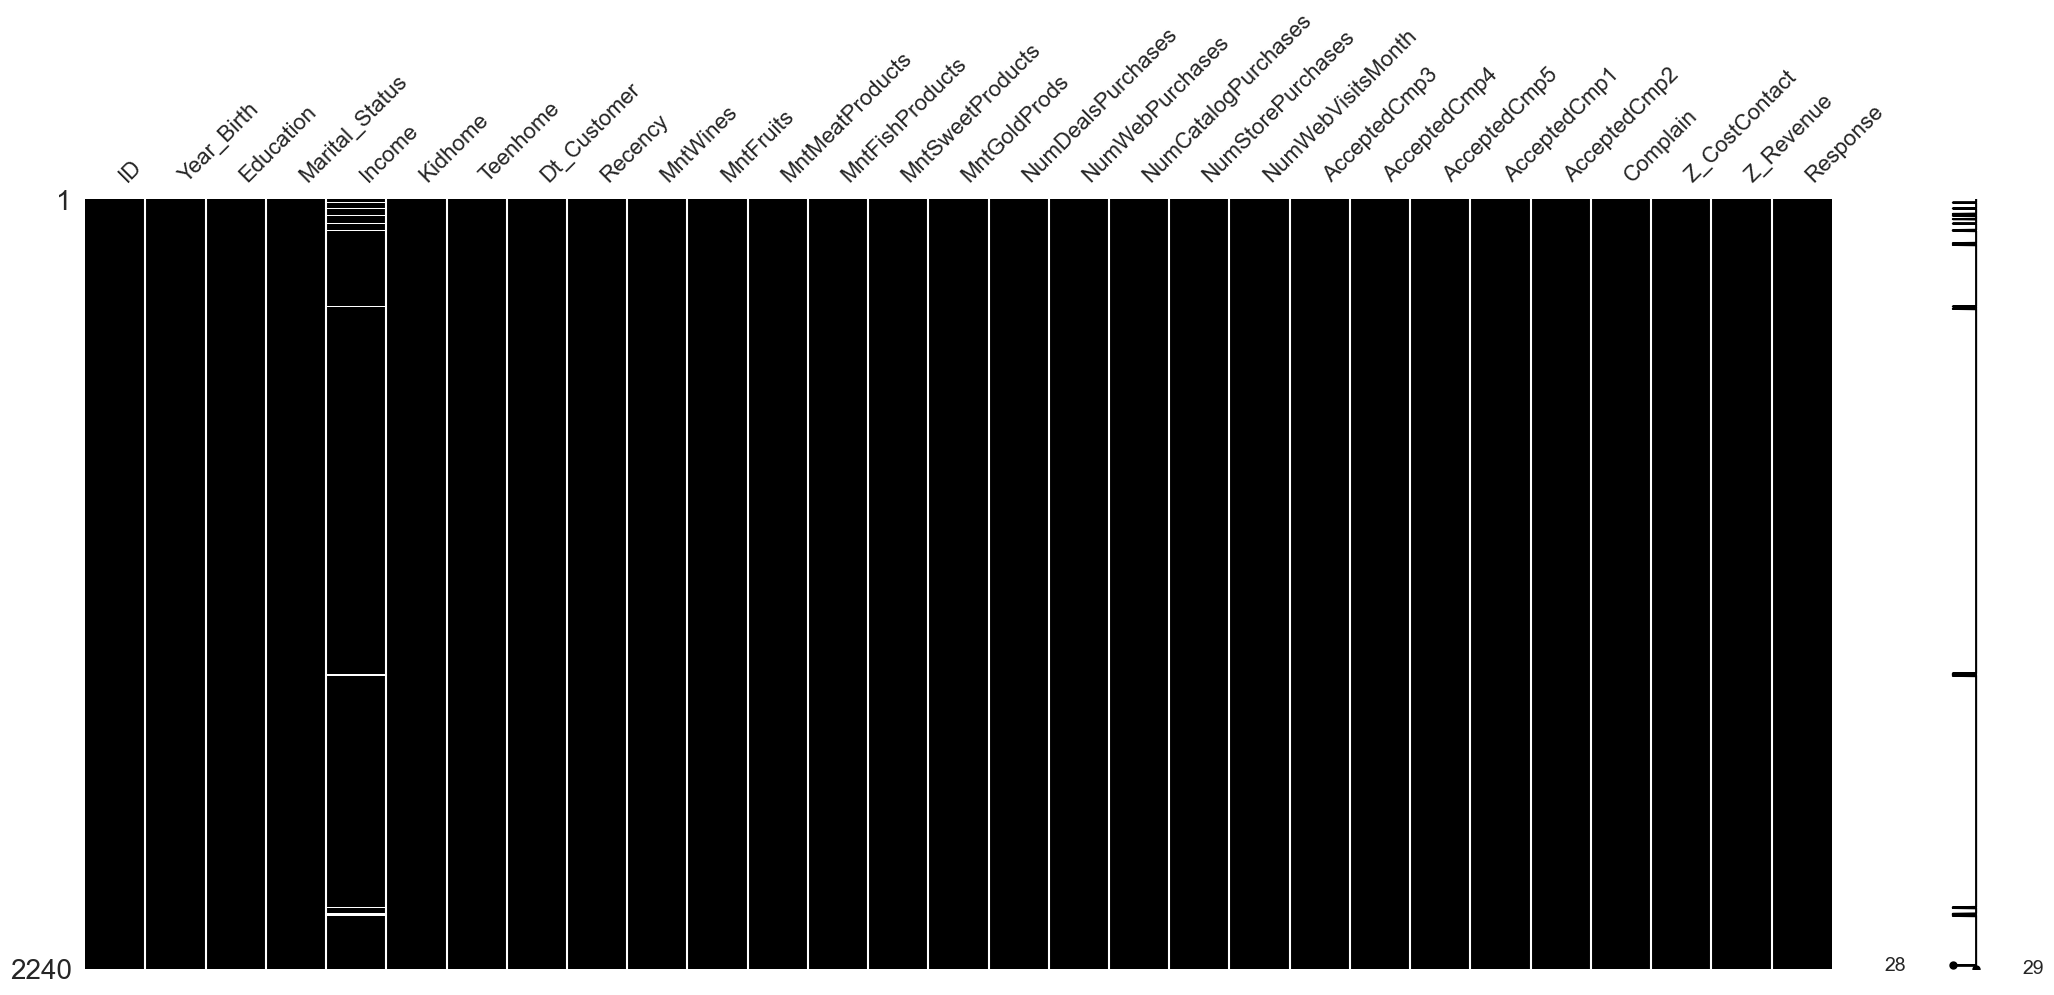

In [145]:
# Visualizar a matriz de valores ausentes
print("\n\n--- Matriz de Valores Ausentes ---")
mn.matrix(df,color = (0,0,0))

###  Verificação de Linhas Duplicadas

In [146]:
num_duplicados = df.duplicated().sum()
print(f"Número de linhas duplicadas encontradas: {num_duplicados}")

Número de linhas duplicadas encontradas: 0


### Contagem de Valores Únicos (Cardinalidade) por Coluna

O `.nunique()` é essencial para identificar colunas constantes.

In [147]:
display(df.nunique())

ID                     2240
Year_Birth               59
Education                 5
Marital_Status            8
Income                 1974
Kidhome                   3
Teenhome                  3
Dt_Customer             663
Recency                 100
MntWines                776
MntFruits               158
MntMeatProducts         558
MntFishProducts         182
MntSweetProducts        177
MntGoldProds            213
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

A análise de cardinalidade revelou que as colunas `Z_CostContact` e `Z_Revenue` possuem apenas **1 valor único**. Elas são constantes e serão removidas na etapa de limpeza por não adicionarem informação útil.

### Conclusão da Análise Diagnóstica

A partir da análise diagnóstica, podemos extrair as seguintes conclusões que guiarão nosso próximo passo:

* **Estrutura Confirmada:** O dataset possui **2240 linhas** e **29 colunas**.
* **Dados Ausentes Identificados:** O diagnóstico confirma que a única coluna com valores faltantes é a `Income`, com **24 registros nulos**.
* **Sem Duplicatas:** Não há linhas duplicadas no dataset.
* **Colunas Constantes:** As colunas `Z_CostContact` e `Z_Revenue` possuem apenas um valor único, indicando que não contribuem com informação útil para a clusterização. Elas serão removidas na etapa de limpeza.
* **Necessidade de Pré-processamento:** O dataset contém uma mistura de tipos de dados (numéricos e de texto) que exigirá tratamento (normalização e codificação) antes da modelagem.

# Data Cleaning

In [164]:
df_clean = df.copy()

### Preenchimento de Dados Ausentes

Para lidar com os dados ausentes, uma abordagem comum é preencher os valores nulos com a mediana da coluna correspondente. Isso é especialmente útil para colunas numéricas, como a `Income`, onde a média pode fornecer uma estimativa razoável do valor ausente sem introduzir viés significativo.

In [167]:
income_median = df_clean['Income'].median()
df_clean['Income'].fillna(income_median, inplace=True)
print(f"Valores nulos em 'Income' após imputação: {df_clean['Income'].isnull().sum()}")

Valores nulos em 'Income' após imputação: 0


### Engenharia de Features
A engenharia de features é uma etapa crucial no pré-processamento de dados, onde transformamos e criamos novas variáveis a partir das existentes para melhorar o desempenho dos modelos de Machine Learning.

In [170]:
# CRIAÇÃO DE FEATURES

# Criação da Feature 'Age' a partir do ano de nascimento
df_clean['Age'] = 2025 - df_clean['Year_Birth']

# Criação da Feature 'Total_Spent' que soma os gastos em diferentes categorias
df_clean['Total_Spent'] = df_clean[[col for col in df.columns if 'Mnt' in col]].sum(axis=1)

# Conversão da coluna 'Dt_Customer' para o formato datetime
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], dayfirst=True)

# Criação da Feature 'Customer_Tenure' que calcula o tempo de relacionamento com o cliente
df_clean['Customer_Tenure'] = (pd.to_datetime('2025-07-06') - df_clean['Dt_Customer']).dt.days # Usando a data da entrega

# Criação da Feature 'Children' que soma as colunas 'Kidhome' e 'Teenhome'
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

# Criação da Feature 'Is_Parent' que indica se o cliente é pai/mãe
df_clean['Is_Parent'] = np.where(df_clean['Children'] > 0, 1, 0)

In [ ]:
# SIMPLIFICAÇÃO DE FEATURES

df_clean['Marital_Status'] = df_clean['Marital_Status'].replace({
    'Married': 'In_Relationship',
    'Together': 'In_Relationship',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
})

In [150]:
median_income = df_cleaned['Income'].median()
df_cleaned['Income'] = df_cleaned['Income'].fillna(median_income)

In [152]:
mnt_cols = [col for col in df_cleaned.columns if 'Mnt' in col]
df_cleaned['Total_Spent'] = df_cleaned[mnt_cols].sum(axis=1)

In [153]:
df_cleaned['Dt_Customer'] = pd.to_datetime(df_cleaned['Dt_Customer'], dayfirst=True)
today = pd.to_datetime('2025-07-04')
df_cleaned['Customer_Tenure'] = (today - df_cleaned['Dt_Customer']).dt.days

In [154]:
df_cleaned['Living_With'] = df_cleaned['Marital_Status'] = df_cleaned['Marital_Status'].replace({
    'Married': 'In_Relationship',
    'Together': 'In_Relationship',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
})

In [155]:
df_cleaned['Children'] = df_cleaned['Kidhome'] + df_cleaned['Teenhome']

In [156]:
df_cleaned['Family_Size'] = df_cleaned['Living_With'].map({
    'Single': 1,
    'In_Relationship': 2
}) + df_cleaned['Children']

In [157]:
df_cleaned['Is_Parent'] = np.where(df_cleaned['Children'] > 0, 1, 0)

In [158]:
df_cleaned['Education'] = df_cleaned['Education'].replace({
  'Basic': 'Undergraduate',
  '2n Cycle': 'Undergraduate',
  'Graduation': 'Graduate',
  'Master': 'Postgraduate',
  'PhD': 'Postgraduate'
})

In [159]:
df_cleaned = df_cleaned.rename(
  columns= {
    'MntWines': 'Wine_Spent',
    'MntFruits': 'Fruit_Spent',
    'MntMeatProducts': 'Meat_Spent',
    'MntFishProducts': 'Fish_Spent',
    'MntSweetProducts': 'Sweet_Spent',
    'MntGoldProds': 'Gold_Spent',
  }
)

In [160]:
to_drop = [
  'ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Marital_Status'
]
df_cleaned.drop(columns=to_drop, axis=1, inplace=True)

# Análise detalhada do dataset

In [161]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Income               2240 non-null   float64
 2   Kidhome              2240 non-null   int64  
 3   Teenhome             2240 non-null   int64  
 4   Recency              2240 non-null   int64  
 5   Wine_Spent           2240 non-null   int64  
 6   Fruit_Spent          2240 non-null   int64  
 7   Meat_Spent           2240 non-null   int64  
 8   Fish_Spent           2240 non-null   int64  
 9   Sweet_Spent          2240 non-null   int64  
 10  Gold_Spent           2240 non-null   int64  
 11  NumDealsPurchases    2240 non-null   int64  
 12  NumWebPurchases      2240 non-null   int64  
 13  NumCatalogPurchases  2240 non-null   int64  
 14  NumStorePurchases    2240 non-null   int64  
 15  NumWebVisitsMonth    2240 non-null   i

In [162]:
print("--- Contagem por Status de Relacionamento (Após Limpeza) ---")
print(df_cleaned["Marital_Status"].value_counts())

print("\n\n--- Contagem por Nível de Escolaridade ---")
print(df_cleaned["Education"].value_counts())

--- Contagem por Status de Relacionamento (Após Limpeza) ---


KeyError: 'Marital_Status'

In [ ]:
# --- PASSO DE ANÁLISE EXTRA: PAIRPLOT ---

print("Gerando o Pairplot... Este gráfico pode demorar um pouco para ser criado.")

# 1. Definir as colunas que queremos visualizar
# Usamos as nossas colunas: Total_Spent e Customer_Tenure
cols_for_pairplot = ["Income", "Recency", "Customer_Tenure", "Age", "Total_Spent", "Is_Parent"]

# 2. Criar o Pairplot
# Usamos o df_cleaned, antes da remoção de outliers, para ter a visão completa
sns.pairplot(
    df_cleaned[cols_for_pairplot], 
    hue="Is_Parent", 
    palette=["#682F2F", "#F3AB60"] # Usando a paleta de cores sugerida
)

# Adicionar um título geral
plt.suptitle('Relação Entre Features-Chave, Separado por Paternidade', y=1.02, fontsize=16)

# Exibir o gráfico
plt.show()

In [ ]:
# Configurando o estilo e a paleta de cores
sns.set_style("whitegrid")
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]

In [ ]:
# --- Capítulo 1: Quem são os Nossos Clientes? (Análise Demográfica) ---
print("Capítulo 1: Perfil Demográfico dos Clientes")
fig1, axes1 = plt.subplots(2, 2, figsize=(18, 12))
fig1.suptitle('Capítulo 1: Quem são os Nossos Clientes?', fontsize=20, y=1.03)

# Gráfico 1.1: Distribuição da Renda
sns.histplot(ax=axes1[0, 0], data=df_cleaned, x='Income', kde=True, color=pallet[0], bins=30)
axes1[0, 0].set_title('Distribuição da Renda Anual', fontsize=14)

# Gráfico 1.2: Distribuição da Idade
sns.histplot(ax=axes1[0, 1], data=df_cleaned, x='Age', kde=True, color=pallet[1], bins=30)
axes1[0, 1].set_title('Distribuição da Idade', fontsize=14)

# Gráfico 1.3: Nível de Escolaridade
sns.countplot(ax=axes1[1, 0], data=df_cleaned, x='Education', order=df_cleaned['Education'].value_counts().index, hue='Education', legend=False)
axes1[1, 0].set_title('Nível de Escolaridade', fontsize=14)

# Gráfico 1.4: Tamanho da Família
sns.countplot(ax=axes1[1, 1], data=df_cleaned, x='Family_Size', hue='Family_Size', legend=False)
axes1[1, 1].set_title('Tamanho da Família (Adultos + Crianças)', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# --- Capítulo 2: Como Eles Compram? (Análise de Consumo) ---
print("\nCapítulo 2: Comportamento de Consumo dos Clientes")
# Calculando o gasto total por categoria
spent_cols = ['Wine_Spent', 'Fruit_Spent', 'Meat_Spent', 'Fish_Spent', 'Sweet_Spent', 'Gold_Spent']
total_spent_by_cat = df_cleaned[spent_cols].sum().sort_values(ascending=False)

fig2, axes2 = plt.subplots(1, 2, figsize=(18, 7))
fig2.suptitle('Capítulo 2: Como Eles Compram?', fontsize=20, y=1.03)

# Gráfico 2.1: Gasto Total por Categoria de Produto
sns.barplot(ax=axes2[0], x=total_spent_by_cat.index, y=total_spent_by_cat.values, palette=pallet)
axes2[0].set_title('Gasto Total por Categoria de Produto', fontsize=14)
axes2[0].set_ylabel('Gasto Total')
axes2[0].tick_params(axis='x', rotation=45)

# Gráfico 2.2: Distribuição do Gasto Total por Cliente
sns.histplot(ax=axes2[1], data=df_cleaned, x='Total_Spent', kde=True, color=pallet[5], bins=40)
axes2[1].set_title('Distribuição do Gasto Total por Cliente', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# --- Capítulo 3: Quais Relações Existem nos Dados? (Análise de Correlação) ---
print("\nCapítulo 3: Relações Entre as Variáveis")
fig3, axes3 = plt.subplots(1, 2, figsize=(18, 7))
fig3.suptitle('Capítulo 3: Quais Relações Existem nos Dados?', fontsize=20, y=1.03)

# Gráfico 3.1: Relação entre Renda e Gasto Total
sns.scatterplot(ax=axes3[0], data=df_cleaned, x='Income', y='Total_Spent', hue='Is_Parent', palette="viridis")
axes3[0].set_title('Renda vs. Gasto Total (Colorido por "É Pai?")', fontsize=14)

# Gráfico 3.2: Heatmap de Correlação (com menos variáveis para ser mais legível)
cols_for_corr = ['Income', 'Age', 'Customer_Tenure', 'Total_Spent', 'Family_Size', 'Children']
corr = df_cleaned[cols_for_corr].corr()
sns.heatmap(ax=axes3[1], data=corr, annot=True, fmt=".2f", cmap='coolwarm')
axes3[1].set_title('Heatmap de Correlação das Principais Features', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=df_cleaned[col], color='lightcoral')
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()


In [ ]:
# Marital Status já foi agrupado em Living_With
sns.countplot(data=df_cleaned, x='Living_With', palette='Set2')
plt.title("Distribuição de Estado Civil (Agrupado)")
plt.show()

sns.countplot(data=df_cleaned, x='Education', palette='Set3', order=df_cleaned['Education'].value_counts().index)
plt.title("Distribuição de Nível de Educação")
plt.xticks(rotation=45)
plt.show()

sns.countplot(data=df_cleaned, x='Is_Parent', palette='Set1')
plt.title("Distribuição de Clientes com ou sem Filhos")
plt.xticks([0, 1], ["Sem filhos", "Com filhos"])
plt.show()


In [ ]:
# Seleciona apenas colunas numéricas
df_corr = df_cleaned.select_dtypes(include=np.number)

plt.figure(figsize=(14, 10))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Mapa de Correlação das Variáveis Numéricas")
plt.show()

In [ ]:
# Gasto total vs. renda
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='Income', y='Total_Spent', hue='Is_Parent', palette='Set1')
plt.title('Gasto Total vs. Renda')
plt.show()

# Idade vs. gasto com vinho
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_cleaned, x='Age', y='Wine_Spent', hue='Education', palette='Set2')
plt.title('Idade vs. Gasto com Vinho')
plt.show()


In [ ]:
# Criando a figura para o nosso dashboard de plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Análise Visual de Features Importantes', fontsize=20, y=1.03)

# Gráfico 1: Boxplot da Renda (Income)
sns.boxplot(ax=axes[0, 0], x=df_cleaned['Income'], color=pallet[0])
axes[0, 0].set_title('Distribuição da Renda (Income)', fontsize=14)

# Gráfico 2: Boxplot do Gasto Total (Total_Spent)
sns.boxplot(ax=axes[0, 1], x=df_cleaned['Total_Spent'], color=pallet[1])
axes[0, 1].set_title('Distribuição do Gasto Total (Total_Spent)', fontsize=14)

# Gráfico 3: Relação entre Renda e Gasto Total
sns.scatterplot(ax=axes[1, 0], data=df_cleaned, x='Income', y='Total_Spent', color=pallet[2])
axes[1, 0].set_title('Renda vs. Gasto Total', fontsize=14)

# Gráfico 4: Boxplot da Idade (Age)
sns.boxplot(ax=axes[1, 1], x=df_cleaned['Age'], color=pallet[3])
axes[1, 1].set_title('Distribuição da Idade (Age)', fontsize=14)

plt.tight_layout()
plt.show()